In [41]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from os.path import join
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from neuro.features import qa_questions
import pandas as pd
from neuro import config
import neuro.viz
import dvu
dvu.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# saved out in main_curves nb
data = joblib.load('results_best_ensemble.pkl')
rr, cols_varied, mets = data['r'], data['cols_varied'], data['mets']

In [43]:
r = rr[rr.qa_questions_version.isin(['', 'v3_boostexamples_merged'])]
r = r[r.num_stories == -1]
r = r[r.ndelays == 8]
r = r[r.subject.isin({'S01', 'S02', 'S03'})]
r = r[r.feature_space.isin({'qa_embedder', 'eng1000'})]
cols_varied = [c for c in cols_varied if not c in ['num_stories']]

# Check results

In [44]:
d = r
d = d[d.feature_selection_alpha >= 0]
d = d[d.feature_selection_stability_seeds > 0]

In [46]:
# print('make sure everything ran both ndelays!')
# display(d.ndelays.value_counts())
# d = d[r.distill_model_path.isna()]
# cols_varied = [c for c in cols_varied if not c in [
# 'distill_model_path']]
# d = d[(d.qa_questions_version == 'v1') *
#   (d.qa_embedding_model == 'mistral 7B')]
if len(cols_varied) > 0:
    d = d.groupby(cols_varied)[mets + ['weight_enet_mask_num_nonzero']].mean()
else:
    d = d[mets]

(
    d
    # .sort_values(by='corrs_test_mean', ascending=False)
    .sort_values(by='corrs_tune_pc_mean', ascending=False)
    .rename(columns=lambda x: x.replace('_', ' ').replace('corrs', ''))
    .style
    .background_gradient(cmap='magma', axis=0)
    .format(precision=3)
)
d = d.reset_index()
d = d[~(d.weight_enet_mask_num_nonzero == 54)]

In [ ]:
# add in non-sparse results
r_nonsparse = r[r.feature_selection_alpha < 0]
r_nonsparse.loc[:, 'weight_enet_mask_num_nonzero'] = 606
r_nonsparse.loc[r_nonsparse['feature_space'] == 'eng1000', 'weight_enet_mask_num_nonzero'] = 985
d = pd.concat([d, r_nonsparse])

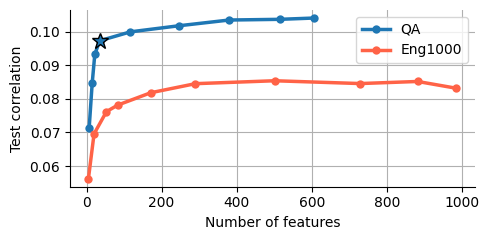

In [60]:
d['(feature_space, ndelays)'] = list(
    zip(d.feature_space, d.ndelays))
d['feature_space'] = d['feature_space'].map(
    lambda x: {'eng1000': 'Eng1000', 'qa_embedder': 'QA'}.get(x, x))
plt.figure(figsize=(5, 2.5))

ax = sns.lineplot(
    data=d,
    x='weight_enet_mask_num_nonzero',
    y='corrs_test_mean',
    #  hue='(qa_questions_version, ndelays)',
    # hue='(feature_space, ndelays)',
      hue_order=['QA', 'Eng1000'],
    hue='feature_space',
    # hue='subject',
    palette=['C0', 'tomato'],
    linewidth=2.5,
    markersize=6,
    markeredgewidth=0,
    marker='o',
    err_style=None,
)

# dvu.line_legend()
# plt.title('B', loc=, fontweight='bold')
plt.xlabel('Number of features')
plt.ylabel('Test correlation')

legend = ax.legend()
ax.legend().set_title('')


# get the x,y coords of the first plotted curve
x, y = ax.lines[0].get_data()
plt.plot(x[3], y[3], marker='*', markersize=12, color='C0',
         markeredgewidth=1, markeredgecolor='black')


# logscale x axis
# plt.xscale('log')

# set ylim bottom to 0.1
# plt.ylim(bottom=0.1)
plt.grid()
plt.tight_layout()
# neuro.viz.savefig('sparsity/sparsity.pdf', bbox_inches='tight')
plt.savefig('sparsity/sparsity.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
print('qa curve', ax.lines[0].get_data())
print('eng1000 curve', ax.lines[1].get_data())
print('percent improvement', ax.lines[0].get_data()[
      1][3] / ax.lines[1].get_data()[1].max())

In [ ]:
# display full width
with pd.option_context('display.max_colwidth', None):
    display(
        d[d.subject == 'S01']
        .groupby(['feature_space'])
        ['weight_enet_mask_num_nonzero'].unique().reset_index()
    )

# Check sparsity levels

In [ ]:
SPARSE_FEATS_COEFS_DIR = join(config.FMRI_DIR_BLOB, 'qa', 'sparse_feats')

In [ ]:

!ls {SPARSE_FEATS_COEFS_DIR}

In [ ]:
alphas_enet, coefs_enet = joblib.load(
    # join(sparse_feats_dir, 'v1_(0, -3, 15).joblib'))
    join(SPARSE_FEATS_COEFS_DIR, 'v3_boostexamples_(0, -3, 15).joblib'))

In [ ]:
for i in range(len(alphas_enet)):
    coef_enet = coefs_enet[:, :, i]
    coef_nonzero = np.any(np.abs(coef_enet) > 0, axis=0)
    print(f'{i=} alpha={alphas_enet[i]:.2e}, n_nonzero={coef_nonzero.sum()}')

### Top questions

In [ ]:
d = r[r.ndelays == 8]
row = d[(d.feature_selection_alpha_index == 3) *
        d.feature_space == 'qa_embedder-10'].iloc[0]

In [ ]:
row[['weights_enet', 'weight_enet_mask', 'weight_enet_mask_num_nonzero']]

In [ ]:
model_params = joblib.load(
    join(row.save_dir_unique, 'model_params.pkl'))

In [ ]:
model_params['weights'].shape

In [ ]:
ndelays = row.ndelays
# weights = model_params['weights']
weights = model_params['weights_pc']
assert weights.shape[0] % ndelays == 0
emb_size = weights.shape[0] / ndelays
weights = weights.reshape(ndelays, int(emb_size), -1)

In [ ]:
weights.shape

In [ ]:
for i in range(29):
    plt.plot(weights[:, i, 4])

In [ ]:
for i in range(29):
    plt.plot(np.abs(weights).mean(axis=-1)[:, i])
plt.xlabel('Delay offset (TRs-1)')
plt.show()

In [ ]:
qs = np.array(qa_questions.get_questions(row.qa_questions_version, full=True))

In [ ]:
mask = row.weight_enet_mask

In [ ]:
qs[mask]

In [ ]:
r['weight_enet_mask']